In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import util

In [3]:
dir_data = Path('/Users/josh/Documents/Harvard/GLM/sabatinilab-glm/data/old-data-version/raw-new/Figure_1_2')
dir_output = Path('/Users/josh/Desktop/example_output_folder')

lst_dict_inputdata = [
    {'session_id': 'WT63_11082021',
    'filepath_signal': dir_data / Path('GLM_SIGNALS_WT69_12192021.txt'),
    'filepath_trial': dir_data / Path('GLM_TABLE_WT69_12192021.txt'),
    'bool_trialTable_matlab_indexed': True,
    'columnName_trialTable_trialId': None,
    'columnRenames_signal': {'Ch1': 'gDA', 'Ch5': 'gACH'},
    'columnRenames_trial': {
        'photometryCenterInIndex': 'CI',
        'photometryCenterOutIndex': 'CO',
        'photometrySideInIndex': 'SI',
        'photometrySideOutIndex': 'SO',
        'hasAllPhotometryData': 'hasData'
    }},
]

def construct_lick(df, signal_left_lick_col, signal_right_lick_col):
    return (df[signal_left_lick_col] + df[signal_right_lick_col]).values

def construct_signal_entry(df, signal_left_in_col, signal_right_in_col):
    return (df[signal_left_in_col] + df[signal_right_in_col]).values

# def construct_SEnt(df, signal_entry_col, trial_entry_col):
#     return (df[signal_entry_col] - df[trial_entry_col]).values

dir_output.mkdir(parents=True, exist_ok=True)

columnName_alignment_trial_start = 'CI'
columnName_alignment_trial_end = 'SO'
trial_index_columns = ['CI', 'CO', 'SI', 'SO',]
trial_num_columns = ['nTrial', 'hasData',]
trial_cat_columns = ['wasRewarded', 'word',]
signal_dense_columns = ['gDA', 'gACH',]
signal_sparse_columns = ['lick', 'sideIn']

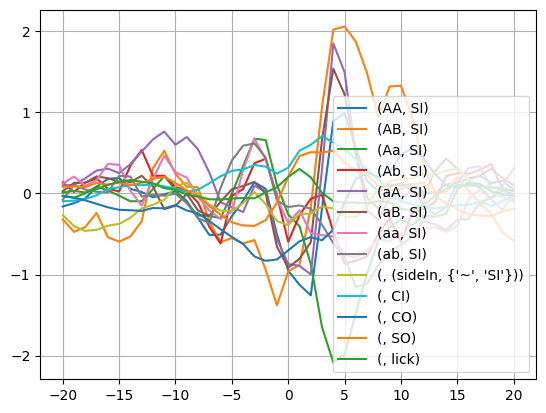

In [36]:
use_history_glm = True

for dict_inputdata in lst_dict_inputdata:
    df_signal = pd.read_csv(dict_inputdata['filepath_signal']).rename(dict_inputdata['columnRenames_signal'], axis=1)
    df_trial = pd.read_csv(dict_inputdata['filepath_trial']).rename(dict_inputdata['columnRenames_trial'], axis=1)
    
    df_trial['nTrial'] = np.arange(df_trial.shape[0])
    df_signal['lick'] = construct_lick(df_signal, 'leftLick', 'rightLick')
    df_signal['sideIn'] = construct_signal_entry(df_signal, 'rightIn', 'leftIn')

    nrows = df_signal.shape[0]
    
    df_trial = df_trial[(df_trial[trial_index_columns] == 0).sum(axis=1) == 0]
    df_trial_indices = df_trial[trial_index_columns]
    
    matrix_signal_sparse = util.Matrix.from_pd_dense_num(df_signal[signal_sparse_columns]).one_hots_to_inx()
    matrix_signal_dense = util.Matrix.from_pd_dense_num(df_signal[signal_dense_columns])
    matrix_trial_inx = util.Matrix.from_pd_sparse_num(nrows, indices=df_trial_indices - 1, values=None, sparse_value=0)
    matrix_trial_num = util.Matrix.from_pd_sparse_num(nrows, indices=df_trial_indices - 1, values=df_trial[trial_num_columns], sparse_value=np.nan)
    matrix_trial_cat = util.Matrix.from_pd_sparse_cat(nrows, indices=df_trial_indices - 1, values=df_trial[trial_cat_columns], sparse_value=np.nan)
    
    matrix_all_preds = util.Matrix([matrix_signal_sparse, matrix_signal_dense, matrix_trial_inx, matrix_trial_num, matrix_trial_cat])

    CI = matrix_all_preds[('', 'CI')]
    CO = matrix_all_preds[('', 'CO')]
    SI = matrix_all_preds[('', 'SI')]
    SO = matrix_all_preds[('', 'SO')]
    lick = matrix_all_preds[('', 'lick')]
    SEnt = (matrix_all_preds[('', 'sideIn')]&~matrix_all_preds[('', 'SI')])
    SI_rew = matrix_all_preds[('wasRewarded', 'SI')]
    SI_wd = matrix_all_preds[('word', 'SI')]

    gDA = matrix_all_preds['gDA']
    gACH = matrix_all_preds['gACH']

    lst_rewards = [CI, CO, SO, lick, SEnt]
    if use_history_glm:
        lst_rewards += [SI_wd]
    else:
        lst_rewards += [SI_rew]
    [reward.set_sparse_value(0.0) for reward in lst_rewards];

    X_reward = util.Matrix(lst_rewards).shift(range(-20, 21))

    y_gDA = gDA
    y_gACH = gACH

    df_X_reward = X_reward.to_pd().sort_index(axis=1)
    srs_y_gDA = y_gDA.to_pd()
    srs_y_gACH = y_gACH.to_pd()

    keep_rows_reward = df_X_reward.isna().sum(axis=1) == 0
    df_X_reward_keep = df_X_reward[keep_rows_reward.values]
    srs_y_gDA_keep = srs_y_gDA[keep_rows_reward.values]

    from sklearn.linear_model import LinearRegression
    lr = LinearRegression(fit_intercept=False)
    lr.fit(df_X_reward_keep, srs_y_gDA_keep)
    srs = pd.Series({a:b for a,b in zip(df_X_reward_keep.columns, lr.coef_)}).unstack().T
    srs.columns = [(col[0][1] if type(col[0]) == tuple else col[0], col[1]) for col in srs.columns]
    srs.plot(grid=True)